In [9]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision
import torch
from albumentations import *
from albumentations.pytorch import ToTensorV2
from torch.utils.data.sampler import SubsetRandomSampler
import glob
import numpy as np
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
class CustomDataset(Dataset):
    def __init__(self, transform_input1=None, transform_input2=None, transform_output1=None, root='./data/', valid=False):
        self.i1_paths = sorted(glob.glob(root+'bg/*'))
        self.i2_paths = sorted(glob.glob(root+'fg_bg/*/*', recursive=True))
        self.o1_paths = sorted(glob.glob(root+'fg_bg_mask/*/*', recursive=True))
        self.transform_i1 = transform_input1
        self.transform_i2 = transform_input2
        self.transform_o1 = transform_output1
        self.valid = valid
        
    def __len__(self):
        if self.valid:
            return int(0.3*len(self.i2_paths))
        return (len(self.i2_paths)-int(0.3*len(self.i2_paths)))
    
    def __getitem__(self, index):
        i1_index = int(index/4000) #Since same copy of i1 is required for 4000 data items
        i1 = Image.open(self.i1_paths[i1_index])
        i2 = Image.open(self.i2_paths[index])
        o1 = Image.open(self.o1_paths[index])
        
        if self.transform_i1:
            i1 = self.transform_i1(i1)
        if self.transform_i2:
            i2 = self.transform_i1(i2)
        if self.transform_o1:
            o1 = self.transform_o1(o1)
            
        return {'i1' : i1, 'i2' : i2, 'o1' : o1}

In [3]:
class train_i1_transforms:
    def __init__(self):
        self.i1_transform = Compose([
            Resize(112, 112),
#             Normalize(mean=[0.4914, 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159]),
            ToTensorV2(),
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.i1_transform(image=img)['image']
        return img

class train_i2_transforms:
    def __init__(self):
        self.i2_transform = Compose([
            Resize(112, 112),
#             Normalize(mean=[0.4914, 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159]),
            ToTensorV2(),
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.i2_transform(image=img)['image']
        return img

class test_i1_transforms:
    def __init__(self):
        self.i1_transform = Compose([
            Resize(112, 112),
#             Normalize(mean=[0.4914, 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159]),
            ToTensorV2(),
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.i1_transform(image=img)['image']
        return img
    
class test_i2_transforms:
    def __init__(self):
        self.i2_transform = Compose([
            Resize(112, 112),
#             Normalize(mean=[0.4914, 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159]),
            ToTensorV2(),
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.i2_transform(image=img)['image']
        return img

class o1_transforms:
    def __init__(self):
        self.o1_transform = Compose([
            Resize(112, 112),
#             Normalize(mean=[0.4914, 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159]),
            ToTensorV2(),
        ])

    def __call__(self, img):
        img = np.array(img)
        img = img[:, :, np.newaxis]
        img = self.o1_transform(image=img)['image']
        return img

In [4]:
def getdata(root='./data/', batch_size=16):
    
    train_dataset = CustomDataset(transform_input1=train_i1_transforms(), transform_input2=train_i2_transforms(), transform_output1=o1_transforms(), root=root)
    valid_dataset = CustomDataset(transform_input1=test_i1_transforms(), transform_input2=test_i2_transforms(), transform_output1=o1_transforms(), root=root, valid=True)

    validation_split = 0.3
    shuffle_dataset = True
    random_seed= 42

    # Creating data indices for training and validation splits:
    dataset_size = len(train_dataset)+len(valid_dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    SEED = 1
    cuda = torch.cuda.is_available() # CUDA?
    print("CUDA Available?", cuda)

    # For reproducibility
    torch.manual_seed(SEED)
    if cuda:
        torch.cuda.manual_seed(SEED)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler, pin_memory=True)
    
    return train_loader, valid_loader

In [5]:
train_loader, valid_loader = getdata(batch_size=8)

CUDA Available? True


In [6]:
sample = next(iter(train_loader))

In [7]:
[(k, v.shape) for k, v in sample.items()]

[('i1', torch.Size([8, 3, 112, 112])),
 ('i2', torch.Size([8, 3, 112, 112])),
 ('o1', torch.Size([8, 1, 112, 112]))]

In [8]:
sample['i1'].shape

torch.Size([8, 3, 112, 112])

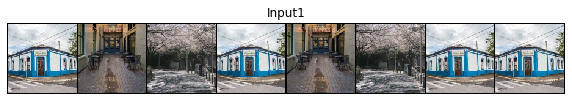

In [9]:
def imshow(inp, nrow=8, title=None):
    """Imshow for Tensor."""
    inp = torchvision.utils.make_grid(inp.detach().cpu(), nrow)
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs = next(iter(train_loader))

# Make a grid from batch
# out1 = torchvision.utils.make_grid(inputs['i1'].detach().cpu(), 8)

imshow(inputs['i1'], title='Input1')

# out2 = torchvision.utils.make_grid(inputs['i2'].detach().cpu(), 8)

# imshow(out2, title='Input2')

# out3 = torchvision.utils.make_grid(inputs['o1'].detach().cpu(), 8)

# imshow(out3, title='Output1')

In [10]:
# x = out1.numpy().transpose((1,2,0))

NameError: name 'out1' is not defined

In [11]:
# plt.imshow(x)

NameError: name 'x' is not defined

In [11]:
class Net(nn.Module):
    def __init__(self, drop=0):
        super(Net, self).__init__()
        self.drop = drop

        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False, groups=32),
            nn.Conv2d(32, 64, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(256, 1, 3, stride=1, padding=1, bias=False),
        )

    def forward(self, inputs):
        x1 = inputs['i1']
        x2 = inputs['i2']

        x1 = self.convblock2(self.convblock1(x1))
        x2 = self.convblock2(self.convblock1(x2))

        x = torch.cat([x1, x2], dim=1)
        x = self.convblock4(self.convblock3(x))

        return x


In [13]:
criterion = nn.BCEWithLogitsLoss()

In [19]:
model = Net()
print(model)

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock4): Sequential(
    (0): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)


In [18]:
model.modules()[0]

TypeError: 'generator' object is not subscriptable

In [ ]:
self._initialize_weights()

def _initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            n = m.weight.size(1)
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

In [20]:
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

In [16]:
path = Path('./experiments/')

In [17]:
def train(model, criterion, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data['i1'] = data['i1'].to(device, dtype=torch.float)
        data['i2'] = data['i2'].to(device, dtype=torch.float)
        data['o1'] = data['o1'].to(device, dtype=torch.float)
        
        optimizer.zero_grad() # making gradients 0, so that they are not accummulated over multiple batches
        output = model(data)
        loss = criterion(output, data['o1'])
        loss.backward() # calculating gradients
        optimizer.step() # updating weights 
        
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data['i1']), len(train_loader.dataset), 100. * batch_idx / len(train_loader),
            loss.item()))
            print('Batch ID: ', batch_idx)
            
            # len(dataloader.dataset) --> total number of input images
            # len(dataloader) --> total no of batches, each to specified size like 16
            
        if batch_idx % 500 == 0:
            out1 = torchvision.utils.make_grid(output.detach().cpu(), 4)
            imshow(out1, title='Predicted (Training)')
            
        if batch_idx % 1000 == 0:
            torch.save(model.state_dict(), path/f"{batch_idx}.pth")

In [48]:
def test(model, criterion, device, test_loader):
    model.eval() #setting model eveluate mode, takes care of batch norm, dropout etc. not required in testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            data['i1'] = data['i1'].to(device, dtype=torch.float)
            data['i2'] = data['i2'].to(device, dtype=torch.float)
            data['o1'] = data['o1'].to(device, dtype=torch.float)
            output = model(data)
            
            test_loss += criterion(output, data['o1'], reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct +=pred.eq(target.view_as(pred)).sum().item()
            
            out1 = torchvision.utils.make_grid(output.cpu(), 4)
            imshow(out1, title='Predicted (validation)')
    test_loss /= len(test_loader.dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [0/14000 (0%)]	Loss: 8.263803
Batch ID:  0


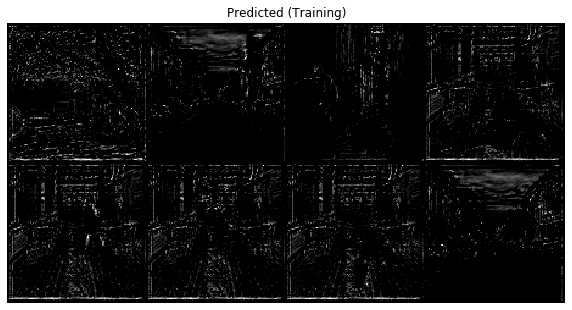

Train Epoch: 1 [400/14000 (3%)]	Loss: -128439001088.000000
Batch ID:  50


KeyboardInterrupt: 

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
for epoch in range(1, 5):
    train(model, criterion, device, train_loader, optim, epoch)

In [83]:
torch.cuda.memory_allocated()/(1024*1024*1024)

0.2066974639892578

In [26]:
len(train_loader.dataset)

14000

In [3]:
from model.data_loader import getdata
from model.network_architecture import Net
from utils import show_image, model_summary
from train import train_model
import torch.nn as nn
import pytorch_ssim

In [10]:
train_loader, valid_loader = getdata(batch_size=64)

CUDA Available? True


In [ ]:
inputs = next(iter(train_loader))
show_image(inputs['i1'], 4, 'Input1')

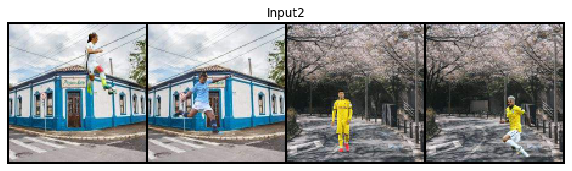

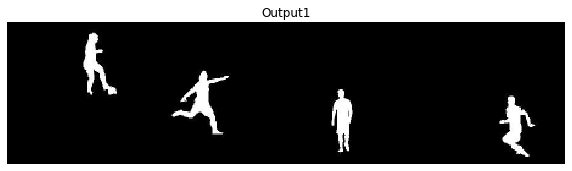

In [4]:
show_image(inputs['i2'], 4, 'Input2')
show_image(inputs['o1'], 4, 'Output1')

In [5]:
model = Net()
print(model)

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convblock3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock5): Se

In [6]:
device = model_summary(model, [(3, 112, 112), (3, 112, 112)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
            Conv2d-5         [-1, 64, 112, 112]           2,048
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]             864
       BatchNorm2d-9         [-1, 32, 112, 112]              64
             ReLU-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 32, 112, 112]             288
           Conv2d-12         [-1, 64, 112, 112]           2,048
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

In [ ]:
trainer = train_model(device)
criterion = pytorch_ssim.SSIM()
trainer.run_model(model, train_loader, valid_loader, criterion,  lr=0.001, epochs=1)

In [ ]:
trainer.run_model(model, train_loader, valid_loader, criterion,  lr=0.01, epochs=5)

In [12]:
import torch
model.load_state_dict(torch.load('./experiments/2000.pth'))

<All keys matched successfully>

In [ ]:
trainer = train_model(device)
criterion = pytorch_ssim.SSIM()
trainer.run_model(model, train_loader, valid_loader, criterion,  lr=0.0001, epochs=10)

In [ ]:
x = torch.randn(4, 32, 56, 56)

In [ ]:
nn.ReLU()(x)